In [1]:
from models import Decoder, Img2Caption

import torch
import torch.nn as nn

import torchvision
from torchvision import transforms

import cv2
from transformers import DebertaTokenizer, DebertaModel

In [2]:
device = "cuda"

In [3]:
tokenizer = DebertaTokenizer.from_pretrained("microsoft/deberta-base")

encoder_dim = 512
encoder = torchvision.models.resnet101(pretrained=True)
encoder.fc = nn.Linear(in_features=2048, out_features=encoder_dim)

decoder = Decoder(tokenizer.vocab_size, 768, encoder_dim, 256, 256, 0.2).to(device)
gptModel = DebertaModel.from_pretrained('microsoft/deberta-base').to(device)

model = Img2Caption(encoder, decoder, gptModel).to(device)

Some weights of the model checkpoint at microsoft/deberta-base were not used when initializing DebertaModel: ['deberta.embeddings.position_embeddings.weight']
- This IS expected if you are initializing DebertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [4]:
model.load_state_dict(torch.load("best_val_model.pt"))

<All keys matched successfully>

In [5]:
def transform(image, dsize=(256, 256)):
    resized_image = cv2.resize(image, dsize)
    torch_transform = transforms.Compose(
        [transforms.ToTensor(), transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])]
    )
    return torch_transform(resized_image)

def get_image(file_name):
    image = cv2.cvtColor(cv2.imread(file_name), cv2.COLOR_BGR2RGB)
    image = transform(image)
    return image

In [6]:
def create_caption_from_image(image_path, model, max_caption_len):
#     setting fake caption to init generation
    max_len = max_caption_len
    targets = torch.zeros(1, max_len).long().to(device)
    # 'cause tokenizer.encode("") results in [1, 2]
    targets[0, 1] = 1
    
#     loading and transforming image
    image = cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB)
    image = transform(image).unsqueeze(0).to(device)

#     making caption
    caption = model(image, targets, teacher_forcing_ratio=1)
    value = tokenizer.decode(torch.argmax(caption.permute(1, 0, 2), axis=2)[0])
    
    return value

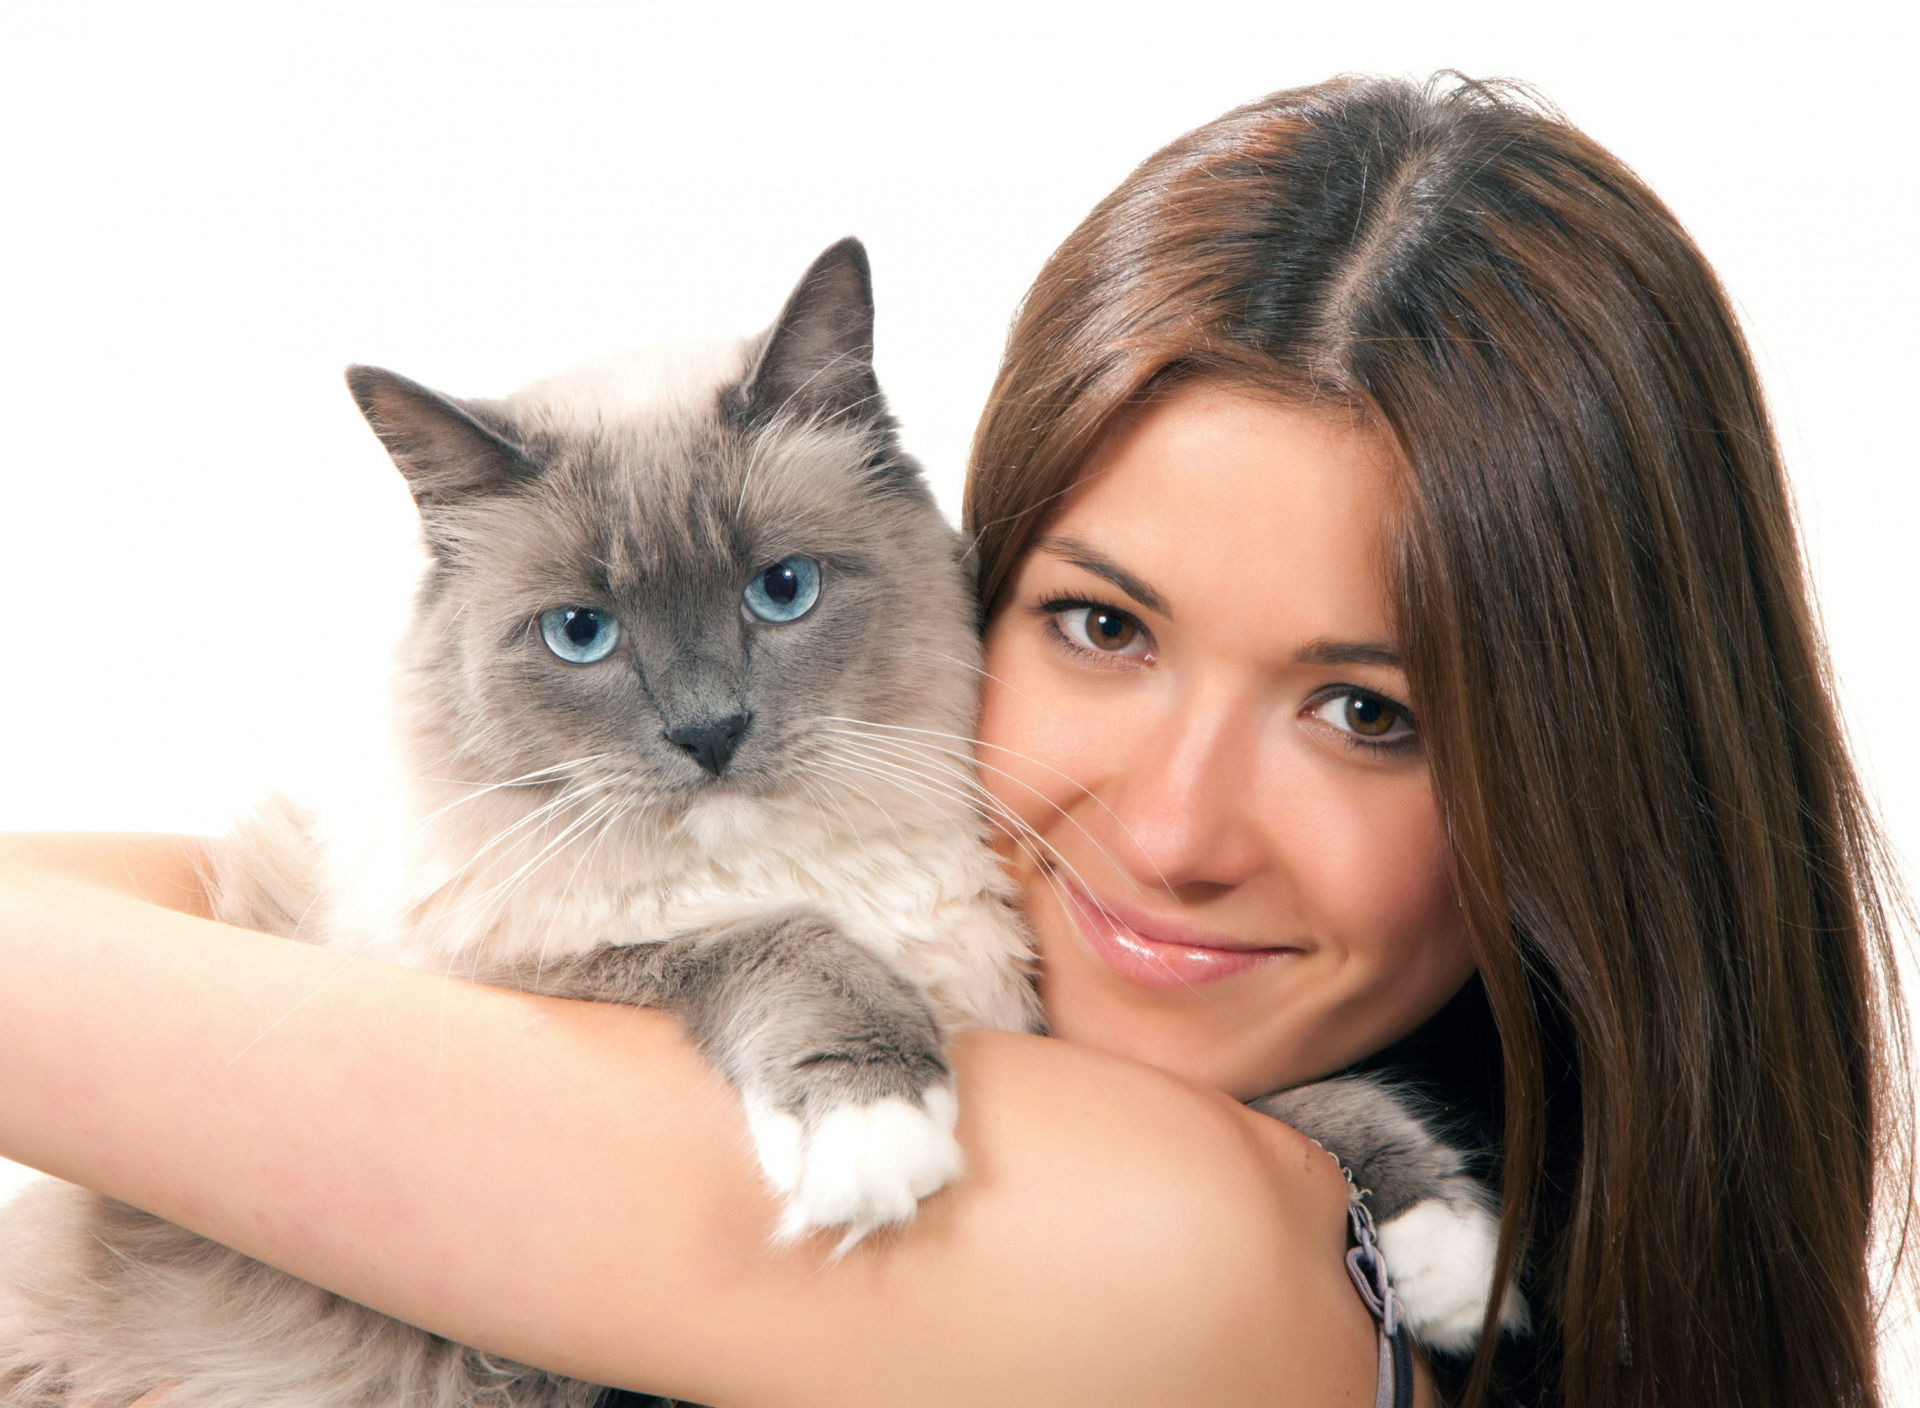

In [10]:
# captioning 1
create_caption_from_image("kot.jpg", model, 32)

'A woman of a a a a a.. a'

In [8]:
# captiononig 2
create_caption_from_image("kot.jpg", model, 32)

'A small cat in a a a a a..'